#### In this Notebook we are able to download several days of CMEMS data and merge it into a single NetCDF file. Then we will import that NetCDF and convert it to a dictionaire of dataframes. We can then apply the 3 algorithms (Canny, BOA and CCA), obtaining a Frontal Probability map for each algorithm and save the results in a folder called CMEMS_seasonal_images.

#### Due to the lower resolution of the SST images of the CMEMS compared to the MUR data, the generated frontal probabilities maps from CMEMS will be of poorer quality and more difficult to interpret

In [1]:
#Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import cv2
import matplotlib
from matplotlib.colors import ListedColormap
from scipy.ndimage import gaussian_filter
import time
import sys
import wget
from math import floor
from pydap.client import open_url
from tqdm import tqdm
import sys
import netCDF4 as nc
import glob
from datetime import date, timedelta
import datetime
import motuclient

import warnings
warnings.filterwarnings("ignore")

plt.rcParams["figure.figsize"] = 12, 8

/home/luisfigueiredo/.local/lib/python3.8/site-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
from ipynb.fs.full.BOA_functions import boa

In [3]:
from ipynb.fs.full.CCA_functions_df import getFrontInWindow
from ipynb.fs.full.CCA_functions_df import CCA_SIED

## -------------------------- DOWNLOAD CMEMS_REANALYSIS DATA ---------------------------------

In [4]:
# this class will be used to parse the motuclient options from a dictionary:
class MotuOptions:
    def __init__(self, attrs: dict):
        super(MotuOptions, self).__setattr__("attrs", attrs)

    def __setattr__(self, k, v):
        self.attrs[k] = v

    def __getattr__(self, k):
        try:
            return self.attrs[k]
        except KeyError:
            return None

In [5]:
#This objective of this function is:   
# post-process the script_template (displayed clicking on VIEW SCRIPT) to create a dictionary; returns this dictionary to feed the download of the data request
def motu_option_parser(script_template, usr, pwd, output_filename, output_directory):
    dictionary = dict([e.strip().partition(" ")[::2] for e in script_template.split('--')])
    dictionary['variable'] = [value for (var, value) in [e.strip().partition(" ")[::2] for e in script_template.split('--')] if var == 'variable']  
    for k, v in list(dictionary.items()):
        if v == '<OUTPUT_DIRECTORY>':
            dictionary[k] = output_directory
        if v == '<OUTPUT_FILENAME>':
            dictionary[k] = output_filename
        if v == '<USERNAME>':
            dictionary[k] = usr
        if v == '<PASSWORD>':
            dictionary[k] = pwd
        if k in ['longitude-min', 'longitude-max', 'latitude-min', 'latitude-max']:
            dictionary[k] = float(v)
        if k in ['date-min', 'date-max']:
            dictionary[k] = v[1:-1]
        dictionary[k.replace('-','_')] = dictionary.pop(k)
    dictionary.pop('python')
    dictionary['auth_mode'] = 'cas'
    return dictionary


In [67]:
def download_CMEMS2(start_date, end_date, USERNAME, PASSWORD, netcdf_name, OUTPUT_DIRECTORY='../data/CMEMS_seasonal_data'):
    
    """
    Function to download CMEMS data for a certain day. start_date and end_date are strings is in format %Y-%m-%d.
    The NetCDF will be stored in the CMEMS_seasonal_data folder.
    The CMEMS has SST data for each hour of the day but we will choose daily data at 12:30
    
    VERY IMPORTANT: --> to download CMEMS data is required a create an account in the Copernicus Marine Service
    So its necessary to have a USERNAME and a PASSWORD
    """
    
    start_date = start_date + ' 12:30:00'
    end_date = end_date + ' 12:30:00'

    sdate = datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
    edate = datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')

    delta = edate-sdate
    dates_list = []
    for i in range(delta.days +1):
        day = sdate + timedelta(days=i)
        day = day.strftime('%Y-%m-%d')
        dates_list.append(day)

    for i in range(len(dates_list)):

        data = ''
        #Get the data in the format we want: data always at 12:30
        data = dates_list[i] + ' 12:30:00'

        OUTPUT_FILENAME = 'CMEMS_' + dates_list[i] +'.nc'

        script_template = f'python -m motuclient \
            --motu https://nrt.cmems-du.eu/motu-web/Motu \
            --service-id IBI_ANALYSISFORECAST_PHY_005_001-TDS \
            --product-id cmems_mod_ibi_phy_anfc_0.027deg-2D_PT1H-m \
            --longitude-min -19 --longitude-max -5 \
            --latitude-min 35 --latitude-max 45 \
            --date-min "{data}" --date-max "{data}" \
            --variable thetao \
            --out-dir <OUTPUT_DIRECTORY> \
            --out-name <OUTPUT_FILENAME> \
            --user <USERNAME> --pwd <PASSWORD>'


        data_request_options_dict_automated = motu_option_parser(script_template, USERNAME, PASSWORD, OUTPUT_FILENAME, OUTPUT_DIRECTORY)
        #print(data_request_options_dict_automated)

        motuclient.motu_api.execute_request(MotuOptions(data_request_options_dict_automated))
    
    
    ds = xr.open_mfdataset('../data/CMEMS_seasonal_data/CMEMS*.nc',combine = 'nested', concat_dim="time")
    
    ds.to_netcdf('../data/CMEMS_seasonal_data/SST_CMEMS_' + netcdf_name + '.nc')
    
    #Now that the several netCDF files are merged into a single NetCDF, we should delete the individual files
    for filename in glob.glob("../data/CMEMS_seasonal_data/CMEMS*.nc"):
        os.remove(filename) 

In [68]:
download_CMEMS2(start_date='2022-8-1', end_date='2022-8-10', USERNAME=USERNAME, PASSWORD=PASSWORD, netcdf_name='test', OUTPUT_DIRECTORY='../data/CMEMS_seasonal_data')

## Import the Data

In [69]:
def get_data(data):
    
    """
    Function to get our netCDF file that is stored in the data directory inside the MUR_seasonal_data folder and convert it to a dataframe.
    The data parameter is the string name of the netCDF file we want to import
    """
    
    base_path = os.getcwd()
    data_folder = os.path.join(base_path, "../data/CMEMS_seasonal_data")  
    
    nc_path = os.path.join(data_folder, data)
    netCDF = xr.load_dataset(nc_path)
    
    df = netCDF.to_dataframe()
    df = df.reset_index()
    
    #df.rename(columns={'lat': 'latitude', 'lon': 'longitude', 'time': 'time', 'analysed_sst':'thetao'}, inplace=True)
    #df['thetao'] = df['thetao']-273.15   
    
    return df


In [70]:
df_test = get_data('SST_CMEMS_test.nc')
df_test

,latitude,longitude,time,thetao
0,35.0,-19.0,2022-08-01 12:30:00,22.281000
1,35.0,-19.0,2022-08-02 12:30:00,22.333000
2,35.0,-19.0,2022-08-03 12:30:00,22.297001
3,35.0,-19.0,2022-08-04 12:30:00,22.331001
4,35.0,-19.0,2022-08-05 12:30:00,22.573002
...,...,...,...,...
1823045,45.0,-5.0,2022-08-06 12:30:00,20.903000
1823046,45.0,-5.0,2022-08-07 12:30:00,20.840000
1823047,45.0,-5.0,2022-08-08 12:30:00,20.882000
1823048,45.0,-5.0,2022-08-09 12:30:00,20.927000


In [80]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1823050 entries, 0 to 1823049
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   latitude   float64       
 1   longitude  float64       
 2   time       datetime64[ns]
 3   thetao     float32       
dtypes: datetime64[ns](1), float32(1), float64(2)
memory usage: 48.7 MB


In [81]:
def get_period(df):
    
    """
    Function that receives a dataframe that has SST data for different days 
    and returns a dictionaire of dataframes (one for each different day) (dict_df) and 
    an array with the different dates its possible to find in our dataframe (specificday)
    """
    
    specificday = [pd.Timestamp(dd).strftime("%Y-%m-%d %H:%M:%S") for dd in df['time'].unique()]
    specificday = np.array(specificday, dtype=np.object)
  
    #create a dictionary to store the data frames for each day
    dict_df = {elem : pd.DataFrame for elem in specificday}

    for key in dict_df.keys():
        dict_df[key] = df[:][df['time'] == key]
        
    return dict_df, specificday


In [82]:
#dict of dataframes (one df for each day) and an array with the diferent dates
dict_df_test, specificday_test = get_period(df_test)

In [83]:
specificday_test

array(['2022-08-01 12:30:00', '2022-08-02 12:30:00',
       '2022-08-03 12:30:00', '2022-08-04 12:30:00',
       '2022-08-05 12:30:00', '2022-08-06 12:30:00',
       '2022-08-07 12:30:00', '2022-08-08 12:30:00',
       '2022-08-09 12:30:00', '2022-08-10 12:30:00'], dtype=object)

In [86]:
# CREATE A FOLDER TO STORE THE IMAGE RESULTS OF THE FRONTAL PROBABILITY MAPS
base_path = os.getcwd()

exist_path = os.path.exists(os.path.join(base_path, '../data/CMEMS_seasonal_images'))   
if not exist_path:                                                                  
    os.makedirs(os.path.join(base_path, '../data/CMEMS_seasonal_images'))     

## ------------------------------------ Canny Algorithm Functions -----------------------------------------

In [87]:

def canny_front_calc(dict_df, Tmin, Tmax, sigma=5, apertureSize=5):  
    
    """
    Function that receives a dataframe with SST data relative to a certain day and returns the front matrix 
    obtained due to the aplication of the Canny algorithm.
    For each image a Gaussian filter (with a certain sigma value) might be applied (depending on the data)
    Tmin and Tmax are the limits of the threshold and apertureSize is the size of the Sobel operator (default=3X3)
    """
    
    #Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
    Temp = dict_df.pivot_table(index='longitude', columns='latitude', values='thetao').T.values
    
    #Convert the temperature values to the uint8 format with values between 0-255
    Temp_day = ((Temp - np.nanmin(Temp)) * (1/(np.nanmax(Temp) - np.nanmin(Temp)) * 255)).astype('uint8')

    Temp_day = np.flipud(Temp_day)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
    Temp_day = gaussian_filter(Temp_day, sigma=sigma)
    
    #apply the canny algorithm from OpenCV
    canny = cv2.Canny(Temp_day, Tmin, Tmax, L2gradient=False, apertureSize=apertureSize)
    
    return canny  #return the matrix (if a pixel was considered a front than its value is 255; otherwise is 0)


In [88]:
def frontal_prob_canny(period, dict_df, Tmin, Tmax, sigma=5, apertureSize=5):
    """
    This function receives several front matrices and for that period calculates the frontal_probability. 
    Then it creates a masked_array so that the continental zone is well defined.
    This masked_array is applied to the frontal probabilities matrix, which is returned
    """
    
    fp = np.zeros((361,505))   
        
    for day in period:             #for each day in period we sum fp with the matrix resulted from canny
        fp = fp + canny_front_calc(dict_df[day], Tmin=Tmin, Tmax=Tmax, sigma=sigma, apertureSize=apertureSize)
    
    fp = fp/(len(period)*255)*100    # to get the fp in percentage 
    
    return fp 

In [89]:

def canny_frontal_prob_visualization(period_txt, period, dict_df, fp_canny, vmin=None, vmax=None):
    
    """
    Function to visualize the map of frontal probability.
    vmin and vmax define the data range that the colormap covers -> it helps for visualization purposes.
    """
    base_path = os.getcwd()
    
    #first we apply the frontal_prob function to a certain period of data
    fp = fp_canny
    
    #Create a mask for our continental zone
    sst = dict_df[period[0]].pivot_table(index='longitude', columns='latitude', values='thetao').T.values  
    mask = np.isnan(np.flipud(sst))    #Boolean array is True where original array (Temp) had Null values
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    
    fp = np.ma.masked_where(mask_dilated==255, fp)
    
    #for the definition of the extent in the imshow() -> so we see the values of long and latitude in our plot
    lat = np.array(dict_df[period[0]]['latitude'].unique())
    lon = np.array(dict_df[period[0]]['longitude'].unique())
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 100)
    newcolor = viridis(np.linspace(0,1,100))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')

    plt.figure()
    plt.imshow(fp, cmap=newcmp, vmin=vmin, vmax=vmax, extent=[lon[0], lon[-1], lat[0], lat[-1]]) 
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50, label='Frontal Probability (%)')
    plt.title("CANNY Frontal Probabilities (CMEMS) " + period_txt, fontsize=20)
    plt.savefig(os.path.join(base_path, '../data/CMEMS_seasonal_images/CANNY_frontal_prob_' + period_txt +'.jpg'))

In [90]:
fp_canny = np.zeros((361,505))    
fp_canny = fp_canny + frontal_prob_canny(period=specificday_test, dict_df=dict_df_test, Tmin=120, Tmax=220, sigma=5, apertureSize=5)

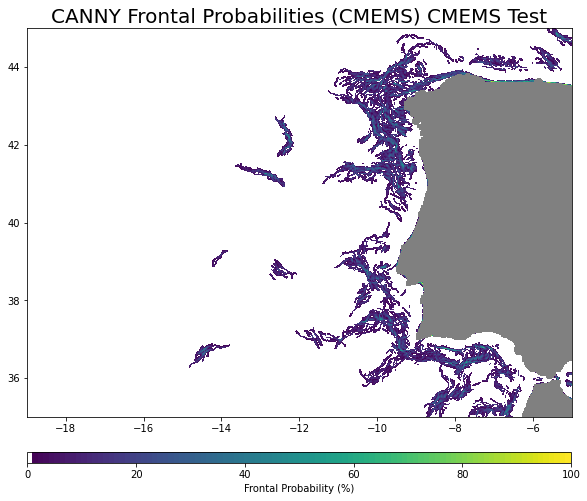

In [91]:
#for the visualization and to save the image in the CMEMS_seasonal_images folder
canny_frontal_prob_visualization(period_txt = 'CMEMS Test', period=specificday_test, dict_df = dict_df_test, fp_canny=fp_canny, vmin=None, vmax=None)

## --------------------- Belkin O'Reilly Algorithm (BOA) Functions --------------------------------

In [92]:
def BOA_aplication(df, threshold=0.4):  
    
    """
    Function to, for a given dataframe with a longitude, latitude and SST columns, 
    identifies fronts through the application of BOA algorithm.
    We also need to define a threshold value to later get the frontal probabilities matrix
    (if the pixel value is greater than the threshold, then it is considered a front, otherwise its not). 
    """
    
    lat = np.array(df['latitude'].unique())
    lon = np.array(df['longitude'].unique())
    ingrid = np.array(df['thetao']).reshape(len(lat), len(lon))
    
    front = boa(lon=lon, lat=lat, ingrid=ingrid, nodata = np.nan, direction = False)
    front = np.flip(front, axis=0)
    front = np.array([[front[j][i] for j in range(len(front))] for i in range(len(front[0])-1,-1,-1)])
    
    front = np.where(front>=threshold, 1, front)    
    front = np.where(front<threshold, 0, front)
    
    return front

In [93]:
def frontal_prob_boa(period, df, threshold=0.3):
    
    """
    Function applies BOA to several images and returns the matrix of frontal probabilities for certain period.
    The matrices resulting from the application of BOA are summed and divided by the number of periods
    to obtain a front probabilities matrix.
    """
    
    fp = np.zeros((361,505))    
        
    for day in period:
        fp = fp + BOA_aplication(df[day], threshold=threshold)
    
    fp = fp/(len(period))*100     #for the calculation of the FP we divide by the number of periods (days) and multiply by 100 (%)
    
    return fp


In [94]:
def boa_frontal_prob_visualization(period, df, period_txt, fp_boa, vmin=None, vmax=None):
    
    """
    Function to visualize the frontal probabilities map.
    """
    base_path = os.getcwd()
    
    fp = fp_boa
    
    lat = np.array(df[period[0]]['latitude'].unique())
    lon = np.array(df[period[0]]['longitude'].unique())
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 100)
    newcolor = viridis(np.linspace(0,1,100))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')
    
    plt.figure()
    plt.imshow(fp, cmap=newcmp, vmin=vmin, vmax=vmax, extent=[lon[0], lon[-1], lat[0], lat[-1]], interpolation='gaussian')
    #extent is to define the extension of x and y axis in image
    plt.xlim([-18.95, -5])
    plt.ylim([35.05, 45])
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50, label='Frontal Probability (%)')
    plt.title("BOA Frontal Probabilities (CMEMS) " + period_txt, fontsize=20)
    plt.savefig(os.path.join(base_path, '../data/CMEMS_seasonal_images/BOA_frontal_prob_' + period_txt +'.jpg'))


In [95]:
fp_boa = np.zeros((361, 505))    #initialize a matrix of 0s with shape (361,505)
fp_boa = fp_boa + frontal_prob_boa(period=specificday_test, df=dict_df_test, threshold=0.4)

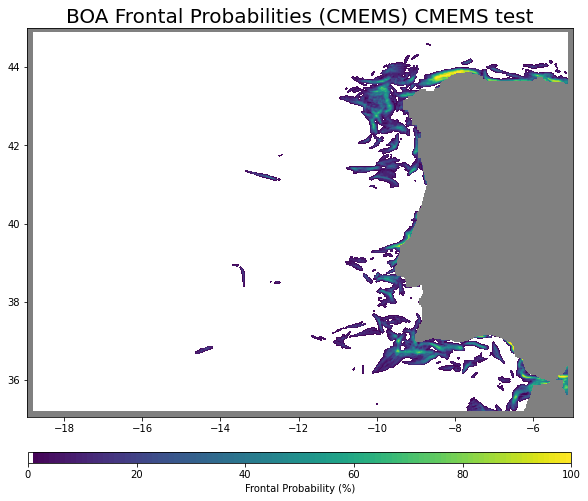

In [96]:
#for the visualization and to save the image in the CMEMS_seasonal_images folder
boa_frontal_prob_visualization(period=specificday_test, df=dict_df_test, period_txt='CMEMS test', fp_boa=fp_boa, vmin=None, vmax=None)

## ---------------------- Cayula-Cornillon Algorithm Functions ----------------------------------

In [97]:
def front_calc(df): 
    
    """
    Function that calculates the fronts matrix. Given an image (SST data respective to one day) it applies the
    Cayula-Cornillon Algorithm for Single Image Edge Detection (CCA-SIED) to discover the fronts.
    It returns the matrix with the fronts: if pixel = 1 it was considered a front, otherwise, pixel = 0
    It basically converts the (x,y) coordinate points to indexes of the frontal probability matrix. These indexes are considered fronts
    The df parameter is the dataframe with the SST data for a certain day
    """
    
    front = np.zeros((361,505))       #initialize a matrix of zeros. This shape is for the CMEMS data
    

    #2 empty arrays that will store the x and y values of the lines that are suposed to be drawn
    x = np.array([])
    y = np.array([])
        
    xdata_final, ydata_final = CCA_SIED(df, shape=(361,505))       
    x = np.append(x, xdata_final)
    y = np.append(y, ydata_final)
        
    cols_x = np.array([])
    for value in x:                     #convert values in array x to the respective index in a (361, 505) matrix
        aux_x = (19+value)/0.027778999999998888      #0.027723         #these numbers are relative to the CMEMS data
        cols_x = np.append(cols_x, aux_x)
    
    rows_y = np.array([])
    for value in y:                     #convert values in array y to the respective index in a (361, 505) matrix
        aux_y = (45-value)/0.027700831024930747       # 0.0277           #these numbers are relative to the CMEMS data
        rows_y = np.append(rows_y, aux_y)
     
    cols_x = np.round(cols_x)
    rows_y = np.round(rows_y)
            
    for i in range(len(cols_x)):   #it could also be len(rows_y)
        front[int(rows_y[i]), int(cols_x[i])] = front[int(rows_y[i]), int(cols_x[i])] + 1
            
    front[front != 0] = 1
    
    return front    

In [98]:
def frontal_prob_cca(period, dict_df):
    
    """
    Function that allows the visualization of the Frontal Probabilities for the Cayula-Cornillon Algorithm (CCA).
    It receives 2 parameters: period (its an array with the several string dates for the period in question) and
    dict_df (which is a dictionaire of dataframes) with data related to those days.
    This function also applies a mask to the frontal probabilities array in order for the continental zone to be 
    well defined. The function plots the frontal probabilities
    """
    front_prob = np.zeros((361, 505))    #for the resolution of the CMEMS data
    for day in period:
        front = front_calc(dict_df[day])
        
        front_prob = front_prob + front
        
    front_prob = front_prob/(len(period))*100    

    return front_prob
    

In [99]:
def CCA_frontal_prob_visualization(period, dict_df, period_txt, fp_cca, vmax=None):   
    
    """
    The purpose of this function is to load the memory from different front matrixes for different days,
    calculate the front probability matrix for the period in question
    and make a visual demonstration of this matrix.
    """
    
    base_path = os.getcwd()
    
    front_prob = fp_cca
    
    #Create a masked_array in order to get the continental zone well defined
    #Convert some df to a numpy array with the SST values for each value of longitude and latitude
    sst = dict_df[period[0]].pivot_table(index='longitude', columns='latitude', values='thetao').T.values    
    mask = np.isnan(np.flipud(sst))       #Boolean array=True where array Temp had Null values (continental zone)
    mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which pixels = 255 when mask=True 
    #Make a dilation to ensure the pixels that belong to the shore are not consideredd fronts
    kernel = np.ones((3,3), np.uint8)
    mask_dilated = cv2.dilate(mask255, kernel)
    front_prob = np.ma.masked_where(mask_dilated==255, front_prob)   
       
    lat = np.array(dict_df[period[0]]['latitude'].unique())
    lon = np.array(dict_df[period[0]]['longitude'].unique())
    #lat = np.unique(lat).round(3)
    #lon = np.unique(lon).round(3)
    
    #Visualization purposes: continenal area in gray, and pixels with value=0 in white   
    viridis = matplotlib.cm.get_cmap('viridis', 30)
    newcolor = viridis(np.linspace(0,1,30))
    white = np.array([1, 1, 1, 1])
    newcolor[0, :] = white
    newcmp = ListedColormap(newcolor)
    newcmp.set_bad(color='gray')

    plt.figure()
    plt.imshow(front_prob, cmap=newcmp, extent = [lon[0], lon[-1], lat[0], lat[-1]], vmax=vmax)    #, interpolation='bilinear' 
    #extent is to define the extention of the x and y axis
    plt.xlim([-18.5, -5])   #to improve visualization
    plt.ylim([35.5, 44.5])  #to improve visualization
    plt.title("Cayula-Cornillon Algorithm Frontal Probability (CMEMS) " + period_txt, fontsize=20)
    plt.colorbar(orientation='horizontal', fraction=0.025, pad=0.08, aspect=50, label='Frontal Probability (%)')
    plt.savefig(os.path.join(base_path, '../data/CMEMS_seasonal_images/CCA_frontal_prob_' + period_txt +'.jpg'))

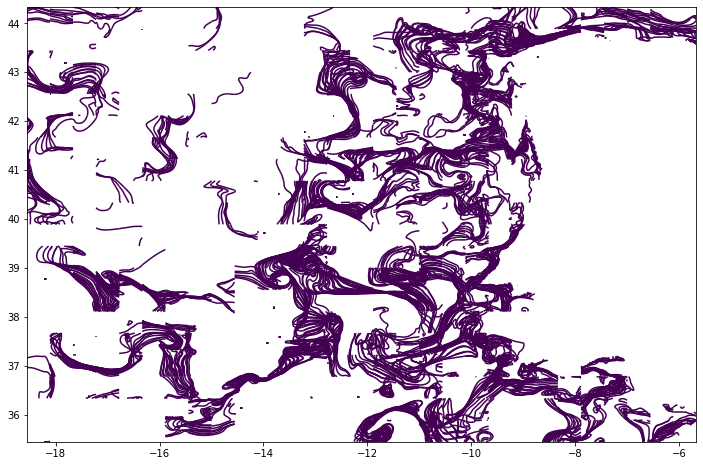

In [100]:
fp_cca = np.zeros((361, 505))     
fp_cca = fp_cca + frontal_prob_cca(period=specificday_test, dict_df=dict_df_test)

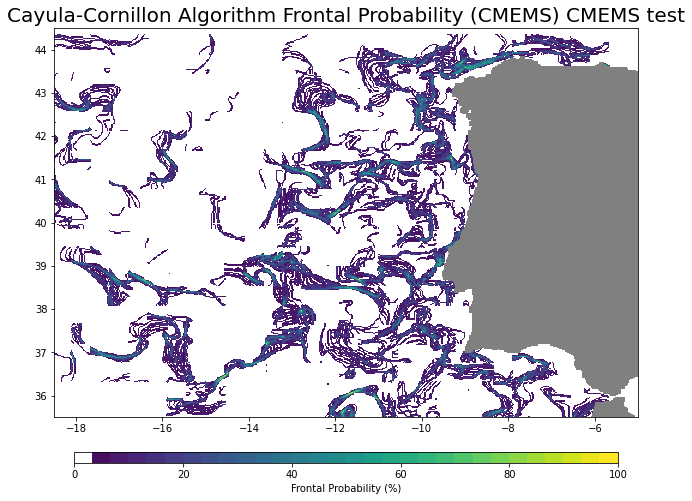

In [101]:
CCA_frontal_prob_visualization(period=specificday_test, dict_df=dict_df_test, period_txt='CMEMS test', fp_cca=fp_cca, vmax=None)